#Preliminaries

In [1]:
!pip install pyunpack
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.1 MB/s 


In [ ]:
from pyunpack import Archive
Archive('/content/drive/MyDrive/EMG_2Chs.7z').extractall("/content/drive/MyDrive/Data")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import keras

#Data Analysis and Sanity Check

In [11]:
# ds = pd.read_csv('/content/drive/MyDrive/Data/EMG-S1/HC-1.csv', usecols = [0])
ds = pd.read_csv('/content/drive/MyDrive/Transfer/Data/EMG-S1/HC-1.csv')
print(ds)

       1.200843e-003  -2.919414e-004
0           0.001233       -0.000226
1           0.001197       -0.000197
2           0.001091       -0.000214
3           0.000924       -0.000259
4           0.000712       -0.000303
...              ...             ...
19994      -0.000236        0.000678
19995      -0.000318        0.000646
19996      -0.000397        0.000564
19997      -0.000447        0.000455
19998      -0.000447        0.000343

[19999 rows x 2 columns]


In [12]:
import numpy as np

ds_np = ds.to_numpy()
print(ds_np)
print(ds_np.shape)

[[ 0.00123342 -0.0002263 ]
 [ 0.00119663 -0.0001973 ]
 [ 0.0010908  -0.0002135 ]
 ...
 [-0.00039712  0.00056425]
 [-0.00044688  0.00045502]
 [-0.00044688  0.00034287]]
(19999, 2)


In [13]:
ds_np = np.reshape(ds_np, (-1))
print(ds_np)
print(ds_np.shape)

[ 0.00123342 -0.0002263   0.00119663 ...  0.00045502 -0.00044688
  0.00034287]
(39998,)


#Data Loader

In [82]:
root = '/content/drive/MyDrive/Transfer/Data'
classes = ['HC', 'I-I', 'L-L', 'M-M', 'R-R', 'T-I', 'T-L', 'T-M', 'T-R', 'T-T']

def read_data_svm(root, mode, Train_size=3):
  # sub_root = os.path.join(root, mode)
  sub_root = root
  subject = []
  label = []
  max = 20000

  if mode=='Train':
    lim = (1, Train_size)
  else:
    lim = (Train_size+1, 6) 

  iter = tqdm(sorted(os.listdir(sub_root)), total=len(sorted(os.listdir(sub_root))))
  for sub_name in iter:
      path = os.path.join(sub_root, sub_name)

      if not 'EMG' in sub_name : continue 

      for name in sorted(os.listdir(path)):
        sub_path = os.path.join(path, name)

        num = (int)(name[-5])
        if num < lim[0] or num > lim[1]:
          continue

        for cl_name in classes:
          if cl_name in name:
            lab = classes.index(cl_name)
            label.append(lab)  
            break

        ds = pd.read_csv(sub_path, usecols = [0])
        ds_np = ds.to_numpy()
        ds_np = np.reshape(ds_np, (-1))
        # sub = np.ravel(sub)
        sub = ds_np

        if len(sub)<max:
          l = max-len(sub)
          pad = [0]*l
          pad = np.array(pad)
          pad = np.reshape(pad, (l,1))
          sub = np.append(sub, pad)

        if len(subject)>0:
          subject = np.vstack((subject, sub))
        else:
          subject = sub  

  label = np.array(label)
  
  return subject, label

def read_data_mlp(root, mode, Train_size=3):
  # sub_root = os.path.join(root, mode)
  sub_root = root
  subject = []
  label = []
  max = 20000

  if mode=='Train':
    lim = (1, Train_size)
  else:
    lim = (Train_size+1, 6) 

  iter = tqdm(sorted(os.listdir(sub_root)), total=len(sorted(os.listdir(sub_root))))
  for sub_name in iter:
      path = os.path.join(sub_root, sub_name)

      if not 'EMG' in sub_name : continue 

      for name in sorted(os.listdir(path)):
        sub_path = os.path.join(path, name)

        num = (int)(name[-5])
        if num < lim[0] or num > lim[1]:
          continue

        for cl_name in classes:
          if cl_name in name:
            lab = classes.index(cl_name)
            # label.append(lab)  
            labl = np.zeros((1, 10))  
            labl[0, lab] = 1
            if len(label)>0:
              # print(label.shape)
              # print(labl.shape)
              # print('-'*100)
              label = np.vstack((label, labl))
            else:
              label = labl
            break

        ds = pd.read_csv(sub_path, usecols = [0])
        ds_np = ds.to_numpy()
        ds_np = np.reshape(ds_np, (-1))
        # sub = np.ravel(sub)
        sub = ds_np

        if len(sub)<max:
          l = max-len(sub)
          pad = [0]*l
          pad = np.array(pad)
          pad = np.reshape(pad, (l,1))
          sub = np.append(sub, pad)

        if len(subject)>0:
          subject = np.vstack((subject, sub))
        else:
          subject = sub  

  label = np.array(label)
  
  return subject, label

#Loading the data

In [83]:
data = {"svm":{"3_3":{}, "4_2":{}, "5_1":{}}, "ann":{"3_3":{}, "4_2":{}, "5_1":{}}}

print("Loading SVM data:")
for k in data["svm"].keys():
    print("  - Split: "+k)
    data["svm"][k]["train"] = read_data_svm(root, 'Train', int(k[0]))
    data["svm"][k]["test"] = read_data_svm(root, 'Test', int(k[0]))

print("Loading ANN data:")
for k in data["ann"].keys():
    print("  - Split: "+k)
    data["ann"][k]["train"] = read_data_mlp(root, 'Train', int(k[0]))
    data["ann"][k]["test"] = read_data_mlp(root, 'Test', int(k[0]))

Loading SVM data:
  - Split: 3_3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  - Split: 4_2


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  - Split: 5_1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Loading ANN data:
  - Split: 3_3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  - Split: 4_2


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  - Split: 5_1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

#feat_ext and dim_red Methods

In [107]:
#PCA and LDA operation

def run_PCA(sub, num_features=100):
    pca = PCA()
    a = pca.fit_transform(sub)
    num = num_features
    b = a[:, :num]
    return b

def run_LDA(sub, lab, num=5):
    lda = LDA()
    a = lda.fit_transform(sub, lab)
    b = a[:, :num]
    return b


#SVM Fitting

In [152]:
#Choose split

split = "5_1"

sub, lab = data["svm"][split]["train"]
test_sub, test_lab = data["svm"][split]["test"]

sub_pca = run_PCA(sub)
test_sub_pca = run_PCA(test_sub)

sub_lda = run_LDA(sub, lab)
test_sub_lda = run_LDA(test_sub, test_lab)

#Fit SVM

train_x = sub
train_y = lab
test_x  = test_sub
test_y  = test_lab


clf = svm.SVC()
clf.fit(train_x, train_y)

SVC()

#Visualization Tools

In [153]:
def visualize(clf, test_sub, test_lab, split="3_3"):
    max = int(split[-1]) * 10.0
    y_pred = clf.predict(np.array(test_sub))
    print('Confusion Matrix')
    
    cf_matrix = confusion_matrix(np.array(test_lab), y_pred)
    df = pd.DataFrame(data=cf_matrix, columns=classes, index=classes)
    fig = plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
    sns.set(font_scale=1.5)

    res = sns.heatmap(df, annot=True, vmin=0.0, vmax=max, center=0.0,
                    fmt='.0f', cmap='BuGn', cbar=False, cbar_kws={"shrink": .82},
                    linewidths=0.6, linecolor='gray')

    res.set_ylabel("Ground-truth")
    res.set_xlabel("Predictions")

    plt.show()
    plt.clf()



Confusion Matrix


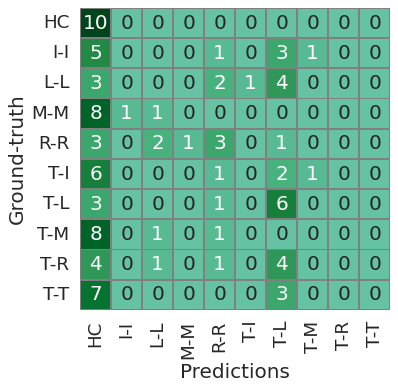

              precision    recall  f1-score   support

           0       0.18      1.00      0.30        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.30      0.30      0.30        10
           5       0.00      0.00      0.00        10
           6       0.26      0.60      0.36        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.19       100
   macro avg       0.07      0.19      0.10       100
weighted avg       0.07      0.19      0.10       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

In [154]:
test_pred = clf.predict(test_x)

visualize(clf, test_x, test_y, split)
report = metrics.classification_report(test_y, test_pred)
print(report)

#ANN Stuff

In [166]:
model_dict = {
    "m1": keras.Sequential([
            keras.layers.Dense(units=5,activation="relu"),
            keras.layers.Dense(units=128,activation="relu"),
            keras.layers.Dense(units=10, activation="softmax")
        ]),
    "m2": keras.Sequential([
            keras.layers.Dense(units=9,activation="relu"),
            keras.layers.Dense(units=512,activation="relu"),
            keras.layers.Dense(units=10, activation="softmax")
        ]),
    "m3": keras.Sequential([
            keras.layers.Dense(units=5,activation="relu"),
            keras.layers.Dense(units=2048,activation="relu"),
            keras.layers.Dense(units=256,activation="relu"),
            keras.layers.Dense(units=10, activation="softmax")
        ]),
    "m4": keras.Sequential([
            keras.layers.Dense(units=5,activation="relu"),
            keras.layers.Dense(units=2048,activation="relu"),
            keras.layers.Dense(units=10, activation="softmax")
        ]),
    "m5": keras.Sequential([
            keras.layers.Dense(units=5,activation="relu"),
            keras.layers.Dense(units=2048,activation="relu"),
            keras.layers.Dense(units=256,activation="relu"),
            keras.layers.Dense(units=10, activation="softmax")
        ]),
    "m6": keras.Sequential([
            keras.layers.Dense(units=5,activation="relu"),
            keras.layers.Dense(units=2048,activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(units=256,activation="relu"),
            keras.layers.Dense(units=10, activation="softmax")
        ])
}

model_nn = model_dict["m5"]

print(model_nn.summary())

model_nn.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

ValueError: ignored

In [157]:
def visualize_ann_results(test_sub, test_lab, split="3_3", save=False, save_name=None):
    max = int(split[-1]) * 10.0
    Y_pred = model_nn.predict(np.array(test_sub))
    y_pred = np.argmax(Y_pred, axis=1)
    Test_lab = np.argmax(test_lab, axis=1)
    print('Confusion Matrix')
    
    cf_matrix = confusion_matrix(np.array(Test_lab), y_pred)
    df = pd.DataFrame(data=cf_matrix, columns=classes, index=classes)
    fig = plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
    sns.set(font_scale=1.5)

    res = sns.heatmap(df, annot=True, vmin=0.0, vmax=max, center=0.0,
                    fmt='.0f', cmap='GnBu', cbar=False, cbar_kws={"shrink": .82},
                    linewidths=0.6, linecolor='gray')

    res.set_ylabel("Ground-truth")
    res.set_xlabel("Predictions")

    plt.show()
    plt.clf()
    if save: plt.savefig("/content/drive/MyDrive/Transfer/Data/Notebook_rb/ann_plots/"+save_name)
    return Test_lab, y_pred



In [99]:
#Choose split

split = "3_3"

sub, lab = data["ann"][split]["train"]
test_sub, test_lab = data["ann"][split]["test"]

sub_pca = run_PCA(sub)
test_sub_pca = run_PCA(test_sub)

sub_lda = run_LDA(sub, data["svm"][split]["train"][1])
test_sub_lda = run_LDA(test_sub, data["svm"][split]["test"][1])

#Data selection

train_x = sub
train_y = lab
test_x  = test_sub
test_y  = test_lab

hist = model_nn.fit(x=np.array(train_x), 
                  y=np.array(train_y),
                  epochs=50, 
                  verbose=1,
                  batch_size=1,                    
                  validation_data=(np.array(test_x), np.array(test_y)),
                  )

ty, test_pred = visualize_ann_results(test_x, test_y)
report = metrics.classification_report(ty, test_pred)
print(report)

Epoch 1/50
300/300 [==============================] - 4s 10ms/step - loss: 0.3612 - accuracy: 0.0533 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.3295 - val_accuracy: 0.1000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/50
300/300 [==============================] - 3s 10ms/step - loss: 0.3333 - accuracy: 0.0600 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.3271 - val_accuracy: 0.1000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/50
300/300 [==============================] - 3s 9ms/step - loss: 0.3317 - accuracy: 0.0667 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.3288 - val_accuracy: 0.1000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/50
300/300 [==============================] - 3s 9ms/step - loss: 0.3314 - accuracy: 0.0700 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.3287 - val_accuracy: 0.1000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 

Text(0.5, 0, 'Epoch')

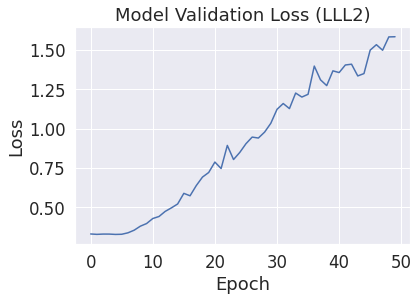

In [100]:

plt.plot(hist.history['val_loss'])

plt.title('Model Validation Loss (LLL2)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

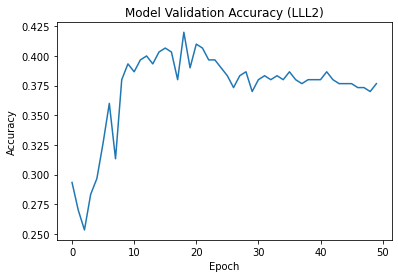

In [ ]:
plt.plot(hist.history['val_accuracy'])

plt.title('Model Validation Accuracy (LLL2)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


Text(0.5, 0, 'Epoch')

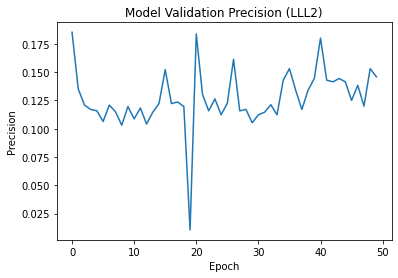

In [ ]:
plt.plot(hist.history['val_precision_17'])

plt.title('Model Validation Precision (LLL2)')
plt.ylabel('Precision')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

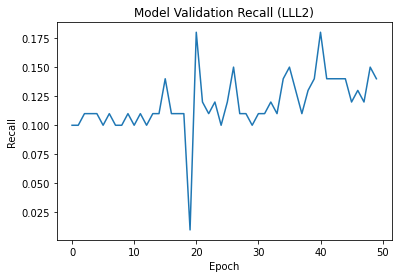

In [ ]:
plt.plot(hist.history['val_recall_17'])

plt.title('Model Validation Recall (LLL2)')
plt.ylabel('Recall')
plt.xlabel('Epoch')


#Visualizations

Confusion Matrix


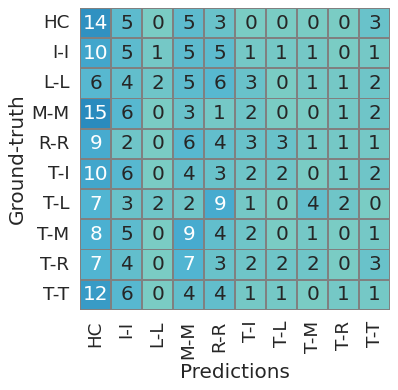

              precision    recall  f1-score   support

           0       0.14      0.47      0.22        30
           1       0.11      0.17      0.13        30
           2       0.40      0.07      0.11        30
           3       0.06      0.10      0.07        30
           4       0.10      0.13      0.11        30
           5       0.12      0.07      0.09        30
           6       0.00      0.00      0.00        30
           7       0.10      0.03      0.05        30
           8       0.00      0.00      0.00        30
           9       0.06      0.03      0.04        30

    accuracy                           0.11       300
   macro avg       0.11      0.11      0.08       300
weighted avg       0.11      0.11      0.08       300



<Figure size 432x288 with 0 Axes>

In [106]:
ty, test_pred = visualize_ann_results(test_x, test_y)
report = metrics.classification_report(ty, test_pred)
print(report)

(300, 20000) (300, 20000) (300, 10) (300, 10)
(300, 20000) (300, 20000) (300, 10) (300, 10)
Epoch 1/50
300/300 [==============================] - 5s 12ms/step - loss: 0.3565 - accuracy: 0.0933 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_loss: 0.3285 - val_accuracy: 0.1000 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 2/50
300/300 [==============================] - 3s 9ms/step - loss: 0.3316 - accuracy: 0.1000 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_loss: 0.3268 - val_accuracy: 0.1000 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 3/50
300/300 [==============================] - 3s 12ms/step - loss: 0.3290 - accuracy: 0.0900 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_loss: 0.3275 - val_accuracy: 0.1000 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 4/50
300/300 [==============================] - 3s 12ms/step - loss: 0.3297 - accuracy: 0.0733 - precision_16: 0.0000e+00 - recall_16: 0.0000e+0

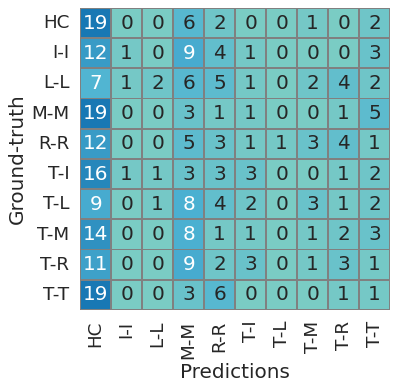

ann_3_3
              precision    recall  f1-score   support

           0       0.14      0.63      0.23        30
           1       0.33      0.03      0.06        30
           2       0.50      0.07      0.12        30
           3       0.05      0.10      0.07        30
           4       0.10      0.10      0.10        30
           5       0.23      0.10      0.14        30
           6       0.00      0.00      0.00        30
           7       0.09      0.03      0.05        30
           8       0.18      0.10      0.13        30
           9       0.05      0.03      0.04        30

    accuracy                           0.12       300
   macro avg       0.17      0.12      0.09       300
weighted avg       0.17      0.12      0.09       300

(300, 20000) (300, 20000) (300, 10) (300, 10)
(300, 100) (300, 100) (300, 10) (300, 10)
Epoch 1/50
300/300 [==============================] - 7s 16ms/step - loss: 0.3524 - accuracy: 0.1067 - precision_17: 0.0000e+00 - recall_17: 0.00

<Figure size 432x288 with 0 Axes>

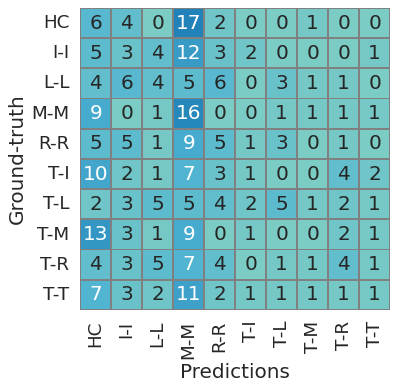

ann_pca_3_3
              precision    recall  f1-score   support

           0       0.09      0.20      0.13        30
           1       0.09      0.10      0.10        30
           2       0.17      0.13      0.15        30
           3       0.16      0.53      0.25        30
           4       0.17      0.17      0.17        30
           5       0.12      0.03      0.05        30
           6       0.36      0.17      0.23        30
           7       0.00      0.00      0.00        30
           8       0.25      0.13      0.17        30
           9       0.12      0.03      0.05        30

    accuracy                           0.15       300
   macro avg       0.15      0.15      0.13       300
weighted avg       0.15      0.15      0.13       300

(300, 20000) (300, 20000) (300, 10) (300, 10)
(300, 5) (300, 5) (300, 10) (300, 10)
Epoch 1/50
300/300 [==============================] - 4s 11ms/step - loss: 0.2419 - accuracy: 0.4900 - precision_18: 0.7174 - recall_18: 0.3300 -

<Figure size 432x288 with 0 Axes>

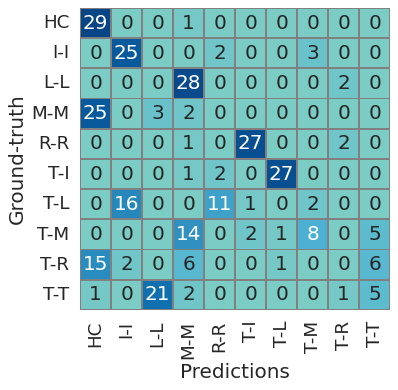

ann_lda_3_3
              precision    recall  f1-score   support

           0       0.41      0.97      0.58        30
           1       0.58      0.83      0.68        30
           2       0.00      0.00      0.00        30
           3       0.04      0.07      0.05        30
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        30
           7       0.62      0.27      0.37        30
           8       0.00      0.00      0.00        30
           9       0.31      0.17      0.22        30

    accuracy                           0.23       300
   macro avg       0.20      0.23      0.19       300
weighted avg       0.20      0.23      0.19       300

(400, 20000) (200, 20000) (400, 10) (200, 10)
(400, 20000) (200, 20000) (400, 10) (200, 10)
Epoch 1/50
400/400 [==============================] - 7s 14ms/step - loss: 0.3498 - accuracy: 0.0975 - precision_19: 0.0000e+00 - recall_

<Figure size 432x288 with 0 Axes>

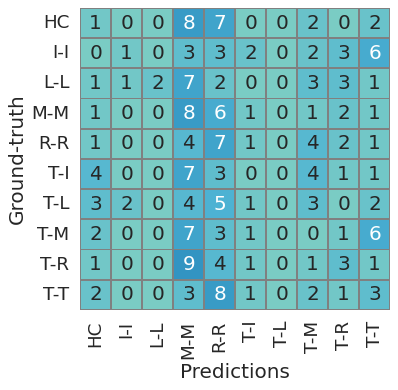

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ann_4_2
              precision    recall  f1-score   support

           0       0.06      0.05      0.06        20
           1       0.25      0.05      0.08        20
           2       1.00      0.10      0.18        20
           3       0.13      0.40      0.20        20
           4       0.15      0.35      0.21        20
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        20
           8       0.19      0.15      0.17        20
           9       0.12      0.15      0.14        20

    accuracy                           0.12       200
   macro avg       0.19      0.12      0.10       200
weighted avg       0.19      0.12      0.10       200

(400, 20000) (200, 20000) (400, 10) (200, 10)
(400, 100) (200, 100) (400, 10) (200, 10)
Epoch 1/50
400/400 [==============================] - 5s 9ms/step - loss: 0.3525 - accuracy: 0.0550 - precision_20: 0.0000e+00 - recall_20: 0.000

<Figure size 432x288 with 0 Axes>

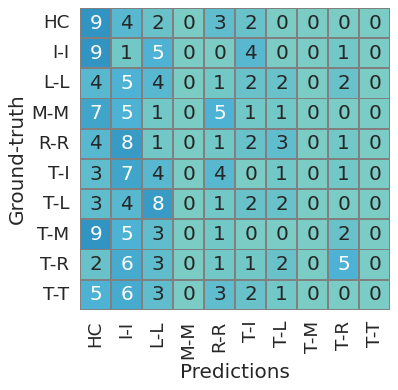

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ann_pca_4_2
              precision    recall  f1-score   support

           0       0.16      0.45      0.24        20
           1       0.02      0.05      0.03        20
           2       0.12      0.20      0.15        20
           3       0.00      0.00      0.00        20
           4       0.05      0.05      0.05        20
           5       0.00      0.00      0.00        20
           6       0.17      0.10      0.12        20
           7       0.00      0.00      0.00        20
           8       0.42      0.25      0.31        20
           9       0.00      0.00      0.00        20

    accuracy                           0.11       200
   macro avg       0.09      0.11      0.09       200
weighted avg       0.09      0.11      0.09       200

(400, 20000) (200, 20000) (400, 10) (200, 10)
(400, 5) (200, 5) (400, 10) (200, 10)
Epoch 1/50
400/400 [==============================] - 6s 13ms/step - loss: 0.2023 - accuracy: 0.5700 - precision_21: 0.7220 - recall_21: 0.4675 -

<Figure size 432x288 with 0 Axes>

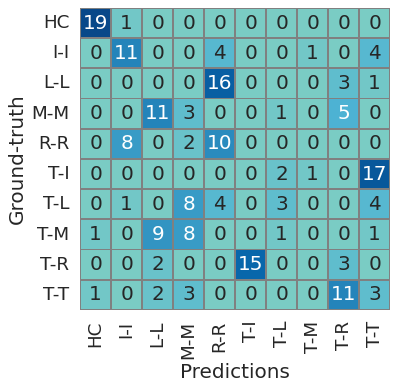

ann_lda_4_2
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.52      0.55      0.54        20
           2       0.00      0.00      0.00        20
           3       0.12      0.15      0.14        20
           4       0.29      0.50      0.37        20
           5       0.00      0.00      0.00        20
           6       0.43      0.15      0.22        20
           7       0.00      0.00      0.00        20
           8       0.14      0.15      0.14        20
           9       0.10      0.15      0.12        20

    accuracy                           0.26       200
   macro avg       0.25      0.26      0.25       200
weighted avg       0.25      0.26      0.25       200

(500, 20000) (100, 20000) (500, 10) (100, 10)
(500, 20000) (100, 20000) (500, 10) (100, 10)
Epoch 1/50
500/500 [==============================] - 6s 10ms/step - loss: 0.3459 - accuracy: 0.0780 - precision_22: 0.0000e+00 - recall_

<Figure size 432x288 with 0 Axes>

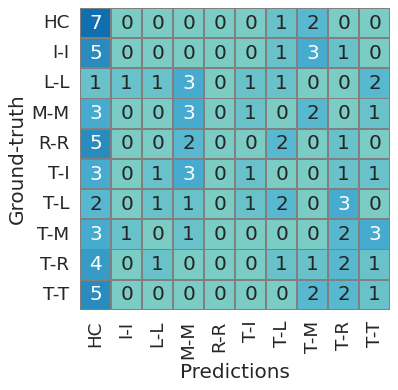

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ann_5_1
              precision    recall  f1-score   support

           0       0.18      0.70      0.29        10
           1       0.00      0.00      0.00        10
           2       0.25      0.10      0.14        10
           3       0.23      0.30      0.26        10
           4       0.00      0.00      0.00        10
           5       0.25      0.10      0.14        10
           6       0.25      0.20      0.22        10
           7       0.00      0.00      0.00        10
           8       0.17      0.20      0.18        10
           9       0.11      0.10      0.11        10

    accuracy                           0.17       100
   macro avg       0.14      0.17      0.13       100
weighted avg       0.14      0.17      0.13       100

(500, 20000) (100, 20000) (500, 10) (100, 10)
(500, 100) (100, 100) (500, 10) (100, 10)
Epoch 1/50
500/500 [==============================] - 6s 10ms/step - loss: 0.3459 - accuracy: 0.0940 - precision_23: 0.0000e+00 - recall_23: 0.00

<Figure size 432x288 with 0 Axes>

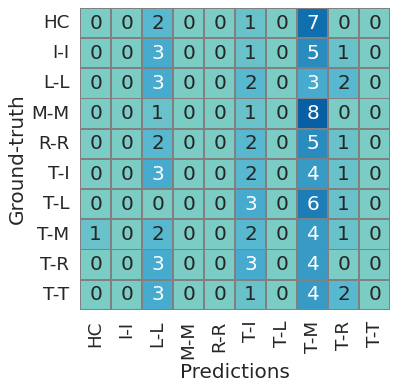

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ann_pca_5_1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.14      0.30      0.19        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.11      0.20      0.14        10
           6       0.00      0.00      0.00        10
           7       0.08      0.40      0.13        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.09       100
   macro avg       0.03      0.09      0.05       100
weighted avg       0.03      0.09      0.05       100

(500, 20000) (100, 20000) (500, 10) (100, 10)
(500, 5) (100, 5) (500, 10) (100, 10)
Epoch 1/50
500/500 [==============================] - 7s 11ms/step - loss: 0.1678 - accuracy: 0.7180 - precision_24: 0.8579 - recall_24: 0.6400 -

<Figure size 432x288 with 0 Axes>

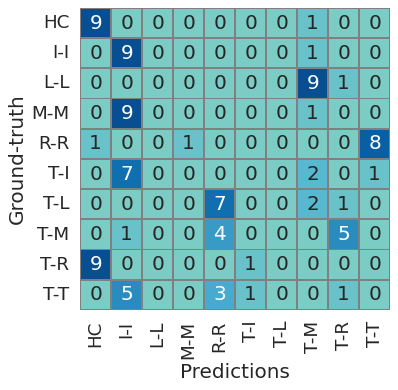

ann_lda_5_1
              precision    recall  f1-score   support

           0       0.47      0.90      0.62        10
           1       0.29      0.90      0.44        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.18       100
   macro avg       0.08      0.18      0.11       100
weighted avg       0.08      0.18      0.11       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

In [168]:
#Choose split

splits = ["3_3", "4_2", "5_1"]
cases = ["", "_pca", "_lda"]

for split in splits:
    for case in cases:
        sub, lab = data["ann"][split]["train"]
        test_sub, test_lab = data["ann"][split]["test"]
        train_x = sub
        train_y = lab
        test_x  = test_sub
        test_y  = test_lab
        print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
        if case == "_pca":
            sub_pca = run_PCA(sub)
            test_sub_pca = run_PCA(test_sub)
            train_x = sub_pca
            test_x  = test_sub_pca

        if case == "_lda":
            sub_lda = run_LDA(sub, data["svm"][split]["train"][1])
            test_sub_lda = run_LDA(test_sub, data["svm"][split]["test"][1])
            train_x = sub_lda
            test_x  = test_sub_lda

        model_nn = keras.Sequential([
            keras.layers.Dense(units=5,activation="relu"),
            keras.layers.Dense(units=2048,activation="relu"),
            keras.layers.Dense(units=256,activation="relu"),
            keras.layers.Dense(units=10, activation="softmax")
        ])
        print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
        model_nn.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
        hist = model_nn.fit(x=np.array(train_x), 
                        y=np.array(train_y),
                        epochs=50, 
                        verbose=1,
                        batch_size=1,                    
                        validation_data=(np.array(test_x), np.array(test_y))
                        )

        ty, test_pred = visualize_ann_results(test_x, test_y, split, save=True, save_name="ann"+case+"_"+split+".png")
        report = metrics.classification_report(ty, test_pred)
        print("ann"+case+"_"+split)
        print(report)

#Misc stuff

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA()
clf.fit(sub, lab)

LinearDiscriminantAnalysis()

In [ ]:
test_pred = clf.predict(test_sub)

report = metrics.classification_report(test_lab, test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.33      0.10      0.15        10
           2       0.00      0.00      0.00        10
           3       0.21      0.30      0.25        10
           4       0.50      0.20      0.29        10
           5       0.12      0.10      0.11        10
           6       0.18      0.30      0.22        10
           7       0.05      0.10      0.07        10
           8       0.11      0.10      0.11        10
           9       0.22      0.40      0.29        10

    accuracy                           0.16       100
   macro avg       0.17      0.16      0.15       100
weighted avg       0.17      0.16      0.15       100



In [ ]:
clf = LDA() # With PCA
clf.fit(sub, lab)

test_pred = clf.predict(test_sub)

report = metrics.classification_report(test_lab, test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.21      0.30      0.25        10
           1       0.00      0.00      0.00        10
           2       0.10      0.10      0.10        10
           3       0.22      0.20      0.21        10
           4       0.09      0.10      0.10        10
           5       0.10      0.10      0.10        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.12      0.10      0.11        10
           9       0.15      0.20      0.17        10

    accuracy                           0.11       100
   macro avg       0.10      0.11      0.10       100
weighted avg       0.10      0.11      0.10       100

